<a href="https://colab.research.google.com/github/Saniru2006/Telco_Customer_Churn_2425606/blob/main/CM2604_2425606_ICW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Packages

In [1]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn imbalanced-learn tensorflow keras-tuner

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")

All libraries imported successfully!


# TASK 1: Exploratory Data Analysis

In [3]:
print("\nTASK 1: EXPLORATORY DATA ANALYSIS")

# Load dataset
print("\nLoading dataset...")
file_path = 'https://raw.githubusercontent.com/Saniru2006/Telco_Customer_Churn_2425606/refs/heads/main/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Display basic information
print("\nDataset preview:")
display(df.head())
print(f"\nDataset info:")
df.info()


TASK 1: EXPLORATORY DATA ANALYSIS

Loading dataset...
Dataset loaded: 7043 rows, 21 columns

Dataset preview:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-

## Data Quality Check

In [4]:
print("\n1.1 DATA QUALITY CHECK")

# Check for missing values
print("\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Check data types
print("\nData types:")
print(df.dtypes.value_counts())

# Check constant columns
constant_cols = []
for col in df.columns:
    if df[col].nunique() == 1:
        constant_cols.append(col)
if constant_cols:
    print(f"\nConstant columns: {constant_cols}")
else:
    print("\nNo constant columns found")


1.1 DATA QUALITY CHECK

Missing values:
Series([], dtype: int64)

Duplicate rows: 0

Data types:
object     18
int64       2
float64     1
Name: count, dtype: int64

No constant columns found


## Data Cleaning

In [5]:
print("\n1.2 DATA CLEANING")

df_clean = df.copy()

# Convert TotalCharges to numeric
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
missing_after = df_clean['TotalCharges'].isnull().sum()
print(f"Missing values in TotalCharges after conversion: {missing_after}")

# Fill missing TotalCharges with 0
df_clean['TotalCharges'].fillna(0, inplace=True)
print("Missing values filled with 0")

# Remove customerID for privacy
df_clean = df_clean.drop('customerID', axis=1)
print("customerID column removed")

print(f"\nCleaned dataset shape: {df_clean.shape}")


1.2 DATA CLEANING
Missing values in TotalCharges after conversion: 11
Missing values filled with 0
customerID column removed

Cleaned dataset shape: (7043, 20)


## Target Variable Analysis


1.3 TARGET VARIABLE ANALYSIS (CHURN)
Churn Distribution:
 No Churn:  5,174 (73.5%)
 Churn:  1,869 (26.5%)
 Baseline Accuracy: 73.5%


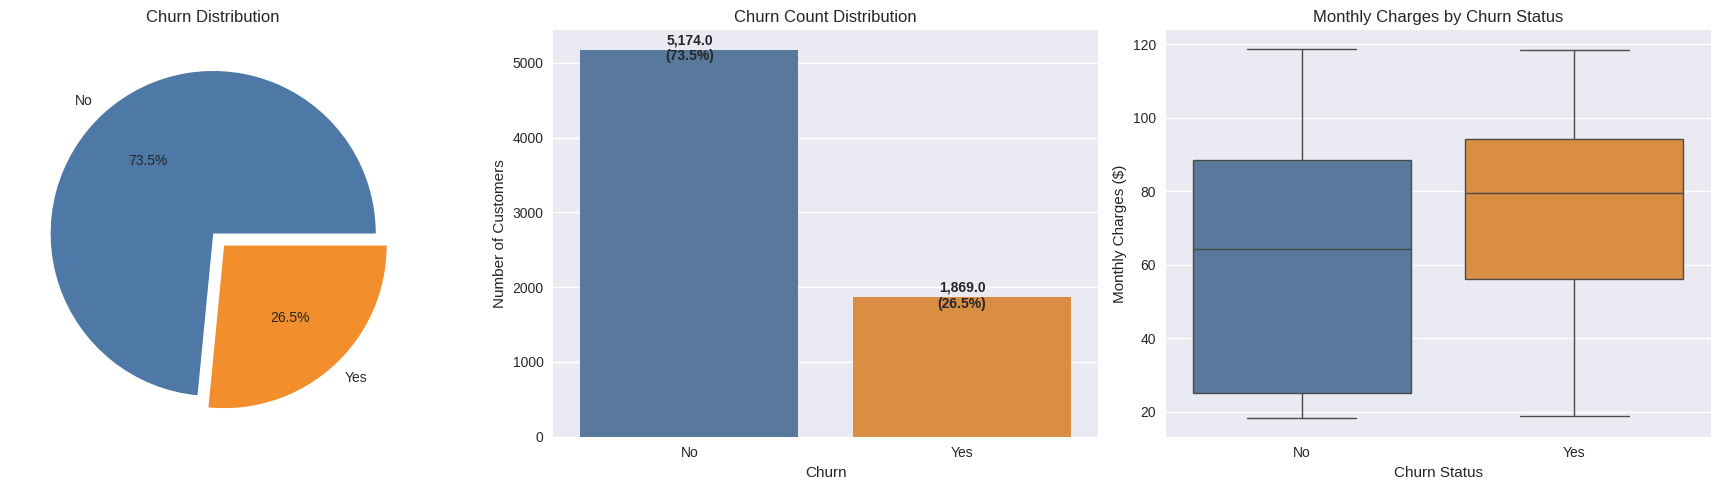

In [6]:
print("\n1.3 TARGET VARIABLE ANALYSIS (CHURN)")

churn_counts = df_clean['Churn'].value_counts()
churn_percentage = df_clean['Churn'].value_counts(normalize=True) * 100

print(f"Churn Distribution:")
print(f" No Churn: {churn_counts['No']:>6,} ({churn_percentage['No']:.1f}%)")
print(f" Churn: {churn_counts['Yes']:>6,} ({churn_percentage['Yes']:.1f}%)")
print(f" Baseline Accuracy: {churn_percentage['No']:.1f}%")

# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Pie chart
axes[0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
            colors=['#4e79a7','#f28e2b'], explode=[0, 0.1])
axes[0].set_title('Churn Distribution')

# Bar chart
sns.countplot(data=df_clean, x='Churn', ax=axes[1], palette={'No': '#4e79a7', 'Yes': '#f28e2b'})
axes[1].set_title('Churn Count Distribution')
axes[1].set_ylabel('Number of Customers')
for p in axes[1].patches:
    axes[1].text(p.get_x() + p.get_width()/2., p.get_height() + 20,
                f'{p.get_height():,}\n({p.get_height()/len(df_clean)*100:.1f}%)',
                ha='center', va='center', fontweight='bold')

# Monthly Charges by Churn Status (Box plot)
sns.boxplot(data=df_clean, x='Churn', y='MonthlyCharges', ax=axes[2], palette={'No': '#4e79a7', 'Yes': '#f28e2b'})
axes[2].set_title('Monthly Charges by Churn Status')
axes[2].set_xlabel('Churn Status')
axes[2].set_ylabel('Monthly Charges ($)')

plt.tight_layout()
plt.show()

## Outlier Detection


1.4 OUTLIER DETECTION
Outliers Analysis (IQR Method):
  tenure: 0 outliers (0.00%)
  MonthlyCharges: 0 outliers (0.00%)
  TotalCharges: 0 outliers (0.00%)


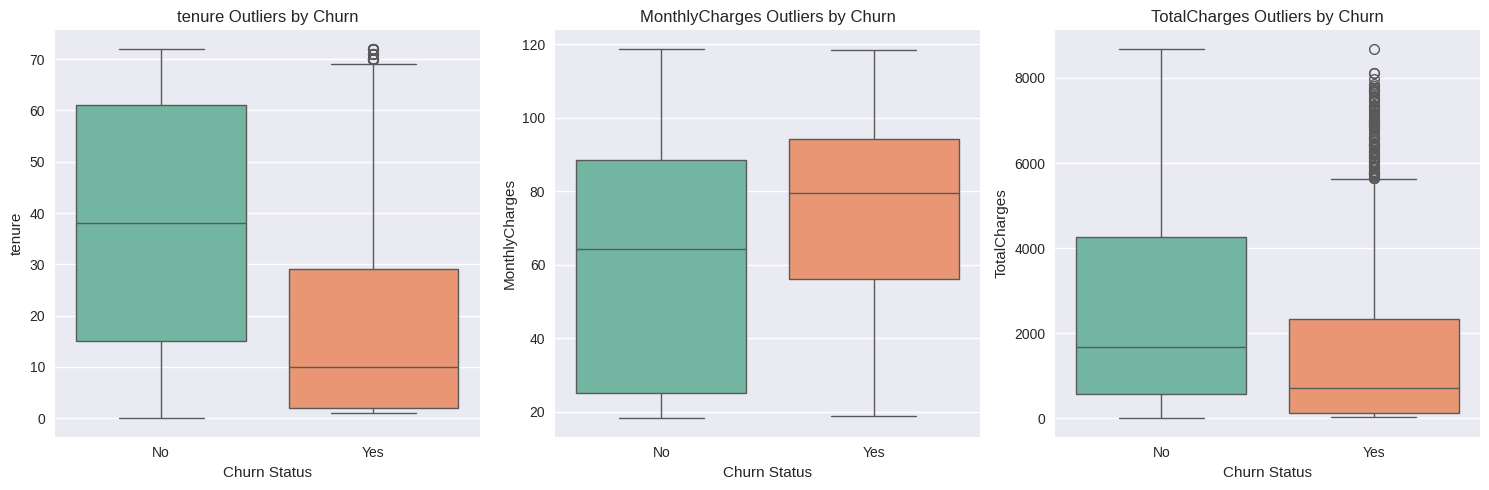

In [7]:
print("\n1.4 OUTLIER DETECTION")

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print("Outliers Analysis (IQR Method):")

for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    print(f"  {col}: {len(outliers)} outliers ({len(outliers)/len(df_clean)*100:.2f}%)")

# Box plots for outlier visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df_clean, x='Churn', y=col, ax=axes[i], palette={'No': '#66c2a5', 'Yes': '#fc8d62'})
    axes[i].set_title(f'{col} Outliers by Churn')
    axes[i].set_xlabel('Churn Status')
plt.tight_layout()
plt.show()

## Numerical Variable Analysis


1.4 NUMERICAL VARIABLES ANALYSIS
Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']

Statistical summary:


,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


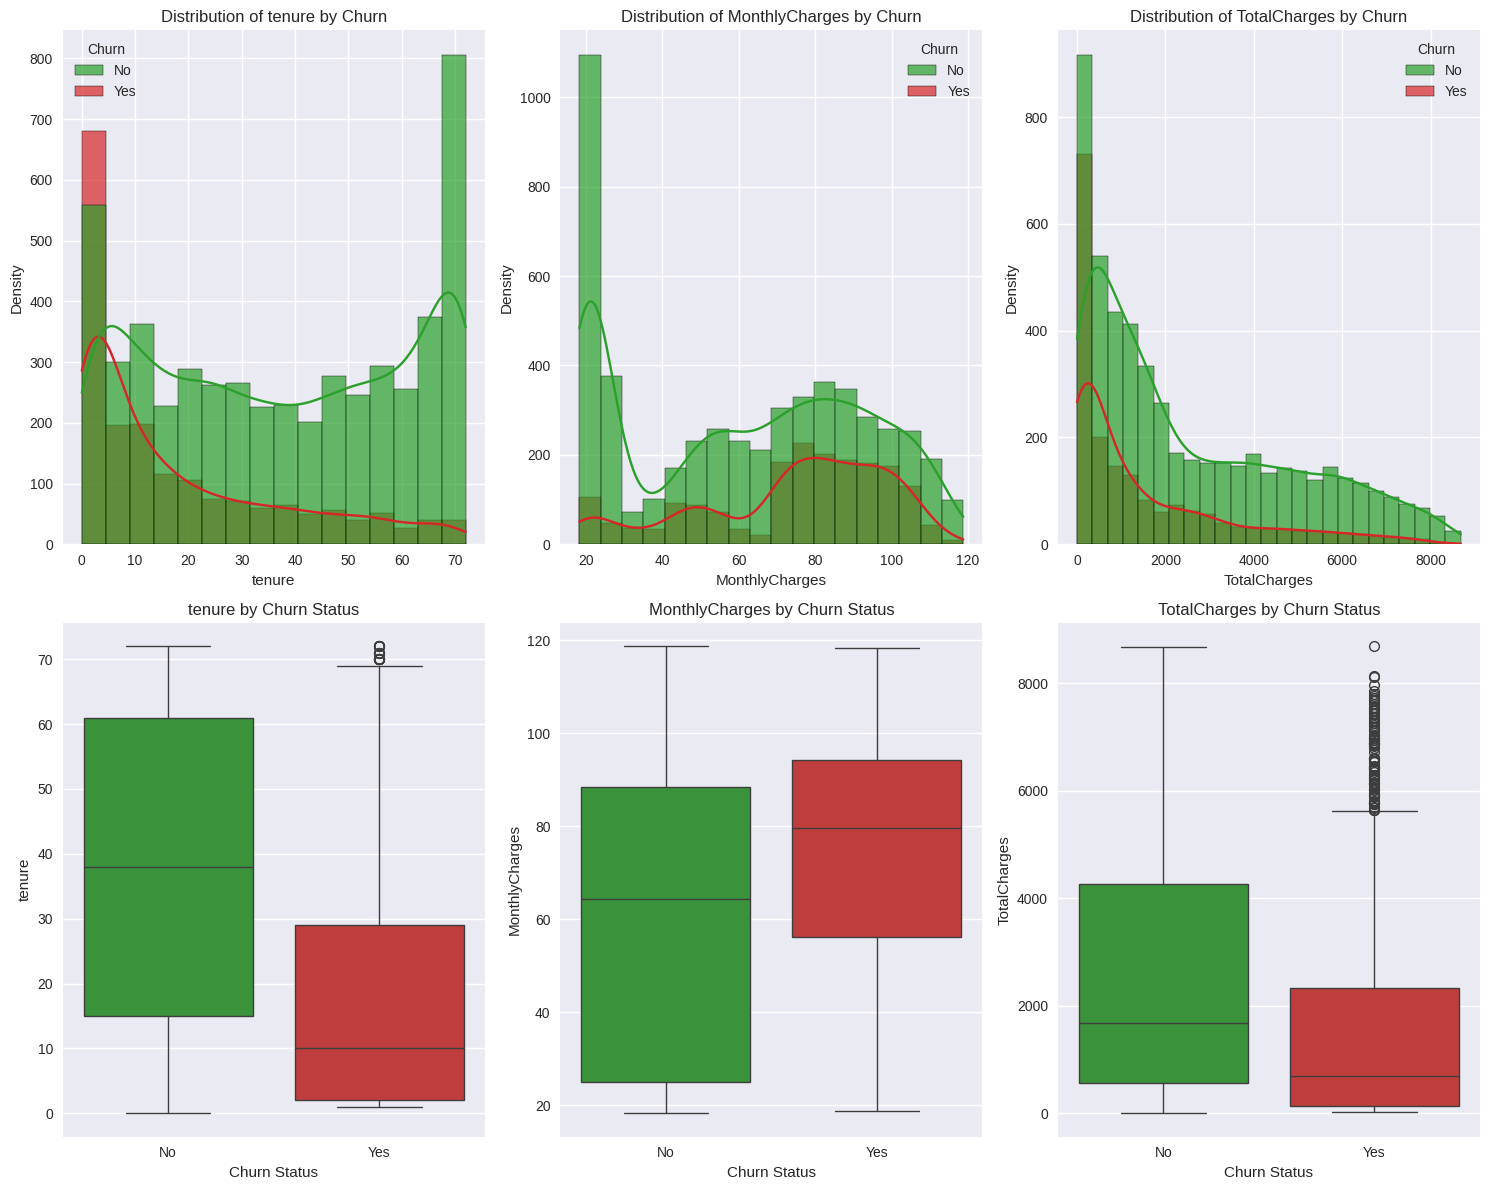


Pairplot of numerical features:


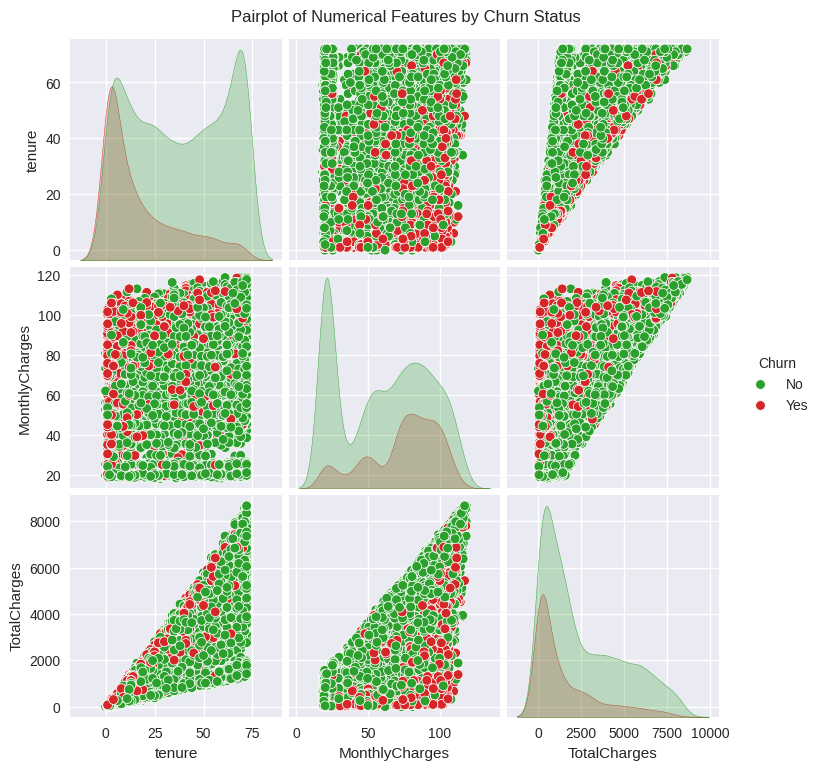


Statistical significance tests:

TENURE Statistics by Churn:
        mean  median    std  min  max
Churn                                
No     37.57    38.0  24.11    0   72
Yes    17.98    10.0  19.53    1   72
  T-statistic: -34.824, P-value: 0.0000
  Significant difference (p < 0.05)

MONTHLYCHARGES Statistics by Churn:
        mean  median    std    min     max
Churn                                     
No     61.27   64.43  31.09  18.25  118.75
Yes    74.44   79.65  24.67  18.85  118.35
  T-statistic: 18.408, P-value: 0.0000
  Significant difference (p < 0.05)

TOTALCHARGES Statistics by Churn:
          mean   median      std    min      max
Churn                                           
No     2549.91  1679.52  2329.95   0.00  8672.45
Yes    1531.80   703.55  1890.82  18.85  8684.80
  T-statistic: -18.707, P-value: 0.0000
  Significant difference (p < 0.05)


In [8]:
print("\n1.4 NUMERICAL VARIABLES ANALYSIS")

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(f"Numerical columns: {numerical_cols}")

print("\nStatistical summary:")
display(df_clean[numerical_cols].describe())

# Distribution with churn hue
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

# Row 1: Histograms with KDE
for i, col in enumerate(numerical_cols):
    sns.histplot(data=df_clean, x=col, hue='Churn', kde=True,
                 ax=axes[0,i], palette={'No': '#2ca02c', 'Yes': '#d62728'}, alpha=0.7)
    axes[0,i].set_title(f'Distribution of {col} by Churn')
    axes[0,i].set_xlabel(col)
    axes[0,i].set_ylabel('Density')

# Row 2: Box plots
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df_clean, x='Churn', y=col,
                ax=axes[1,i], palette={'No': '#2ca02c', 'Yes': '#d62728'})
    axes[1,i].set_title(f'{col} by Churn Status')
    axes[1,i].set_xlabel('Churn Status')
    axes[1,i].set_ylabel(col)
plt.tight_layout()
plt.show()

# Pairplot
print("\nPairplot of numerical features:")
sns.pairplot(df_clean, hue='Churn', vars=numerical_cols, palette={'No': '#2ca02c', 'Yes': '#d62728'})
plt.suptitle('Pairplot of Numerical Features by Churn Status', y=1.02)
plt.show()

# Statistical tests
# Statistical tests
print("\nStatistical significance tests:")
for col in numerical_cols:
    churn_yes = df_clean[df_clean['Churn'] == 'Yes'][col]
    churn_no = df_clean[df_clean['Churn'] == 'No'][col]

    # Calculate statistics
    stats_df = df_clean.groupby('Churn')[col].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
    print(f"\n{col.upper()} Statistics by Churn:")
    print(stats_df)

    # T-test
    t_stat, p_value = stats.ttest_ind(churn_yes, churn_no, equal_var=False)
    print(f"  T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  Significant difference (p < 0.05)")
    else:
        print("  No significant difference")

## Categorical Variable Analysis


1.6 CATEGORICAL VARIABLES ANALYSIS
Number of categorical variables: 16


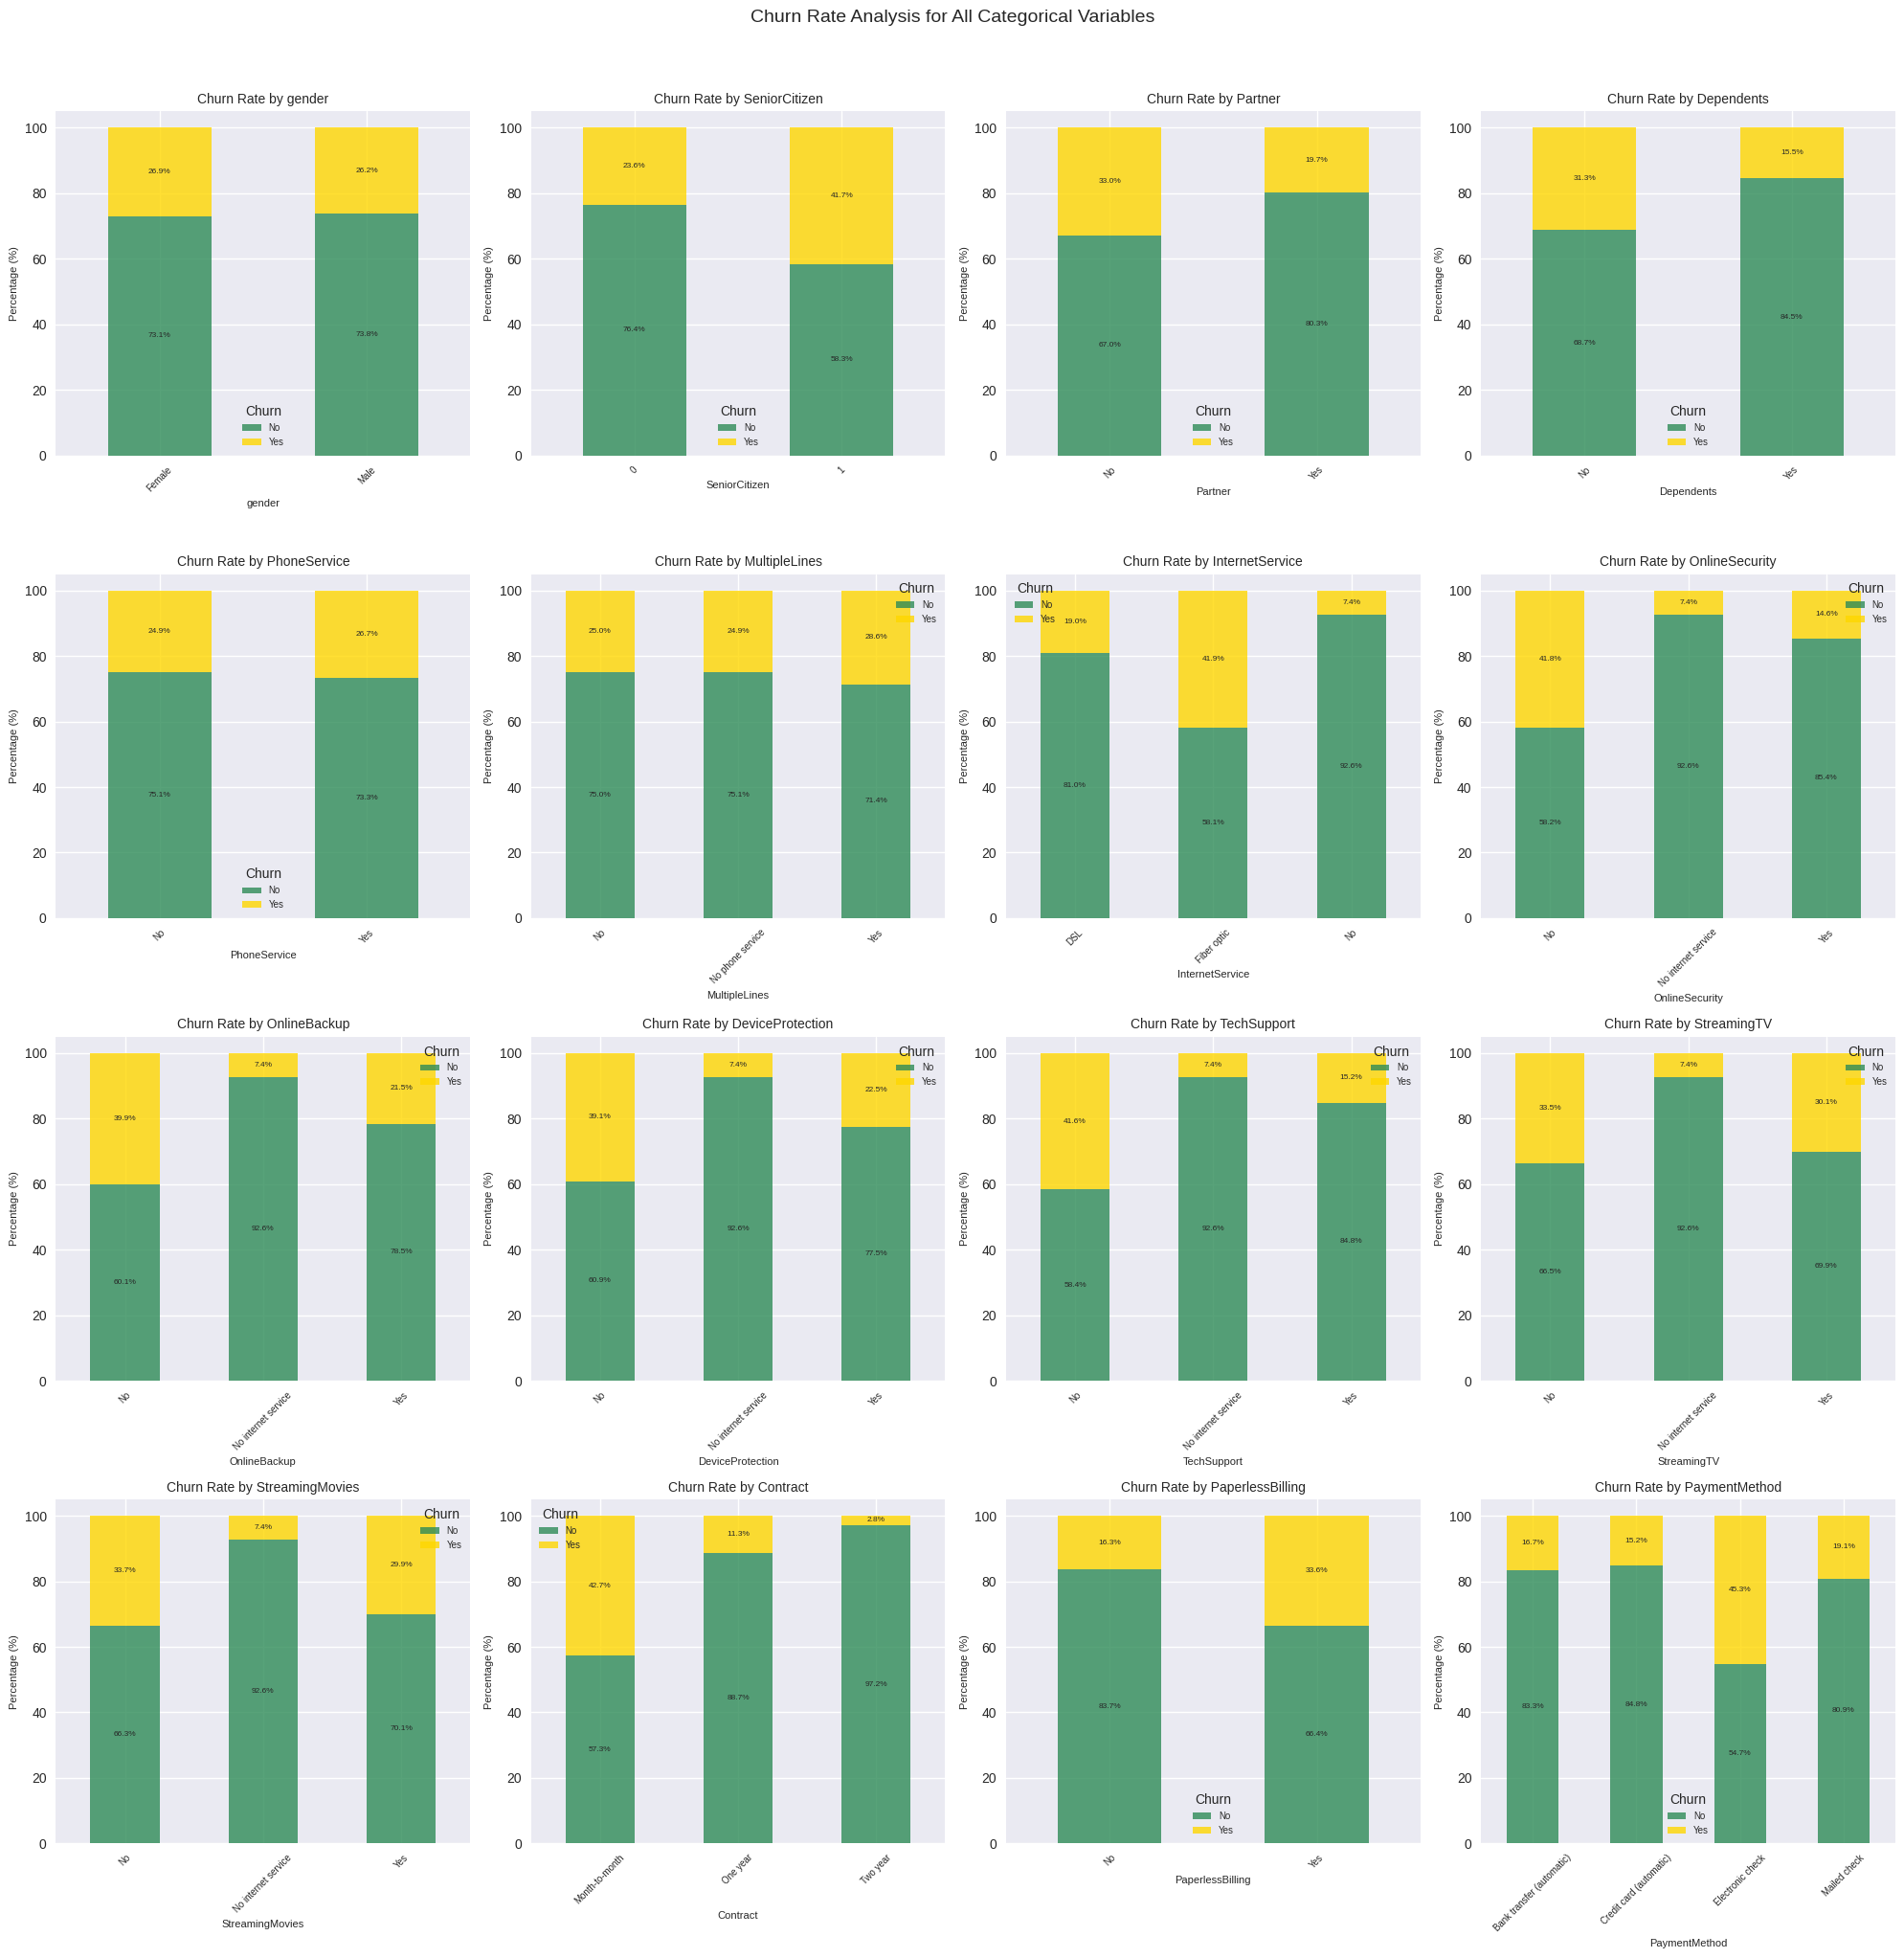


Key insights from categorical analysis:

Contract:
  Highest Risk: Month-to-month (42.7% churn)
  Lowest Risk: Two year (2.8% churn)
  Risk Difference: 39.9%

InternetService:
  Highest Risk: Fiber optic (41.9% churn)
  Lowest Risk: No (7.4% churn)
  Risk Difference: 34.5%

PaymentMethod:
  Highest Risk: Electronic check (45.3% churn)
  Lowest Risk: Credit card (automatic) (15.2% churn)
  Risk Difference: 30.0%

TechSupport:
  Highest Risk: No (41.6% churn)
  Lowest Risk: No internet service (7.4% churn)
  Risk Difference: 34.2%

OnlineSecurity:
  Highest Risk: No (41.8% churn)
  Lowest Risk: No internet service (7.4% churn)
  Risk Difference: 34.4%

SeniorCitizen:
  Highest Risk: 1 (41.7% churn)
  Lowest Risk: 0 (23.6% churn)
  Risk Difference: 18.1%

Senior Citizen Special Analysis:
  Non-Senior Citizens (0): 23.6% churn rate
  Senior Citizens (1): 41.7% churn rate
  Seniors are 1.8x more likely to churn


In [9]:
print("\n1.6 CATEGORICAL VARIABLES ANALYSIS")

categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

print(f"Number of categorical variables: {len(categorical_cols)}")

# Analyze all categorical variables with churn rate
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    # Create cross tabulation for churn rate
    cross_tab = pd.crosstab(df_clean[col], df_clean['Churn'], normalize='index') * 100

    # Plot stacked bar chart
    bars = cross_tab.plot(kind='bar', ax=axes[i], stacked=True,
                         color=['#2e8b57','#ffd700'], alpha=0.8)
    axes[i].set_title(f'Churn Rate by {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Percentage (%)', fontsize=8)
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)
    axes[i].legend(title='Churn', fontsize=7)

    # Add percentage annotations
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.1f%%', label_type='center', fontsize=6)

plt.suptitle('Churn Rate Analysis for All Categorical Variables', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Key insights from categorical analysis
print("\nKey insights from categorical analysis:")
key_categories = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport', 'OnlineSecurity', 'SeniorCitizen']

for var in key_categories:
    churn_rates = df_clean.groupby(var)['Churn'].value_counts(normalize=True).unstack()['Yes'] * 100
    max_churn_category = churn_rates.idxmax()
    max_churn_rate = churn_rates.max()
    min_churn_category = churn_rates.idxmin()
    min_churn_rate = churn_rates.min()

    print(f"\n{var}:")
    print(f"  Highest Risk: {max_churn_category} ({max_churn_rate:.1f}% churn)")
    print(f"  Lowest Risk: {min_churn_category} ({min_churn_rate:.1f}% churn)")
    print(f"  Risk Difference: {max_churn_rate - min_churn_rate:.1f}%")

# Special analysis for Senior Citizens
print("\nSenior Citizen Special Analysis:")
if 'SeniorCitizen' in df_clean.columns:
    senior_churn_rates = df_clean.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True).unstack()['Yes'] * 100
    print(f"  Non-Senior Citizens (0): {senior_churn_rates[0]:.1f}% churn rate")
    print(f"  Senior Citizens (1): {senior_churn_rates[1]:.1f}% churn rate")
    print(f"  Seniors are {senior_churn_rates[1]/senior_churn_rates[0]:.1f}x more likely to churn")

## Correlation Analysis


1.6 CORRELATION ANALYSIS (Numerical Features Only - No Churn)
Numerical features available: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Correlation Matrix of Numerical Features (without Churn):

Correlation coefficients between numerical features:
------------------------------------------------------------
tenure               ↔ TotalCharges        :   0.826 (Strong positive correlation)
MonthlyCharges       ↔ TotalCharges        :   0.651 (Moderate positive correlation)


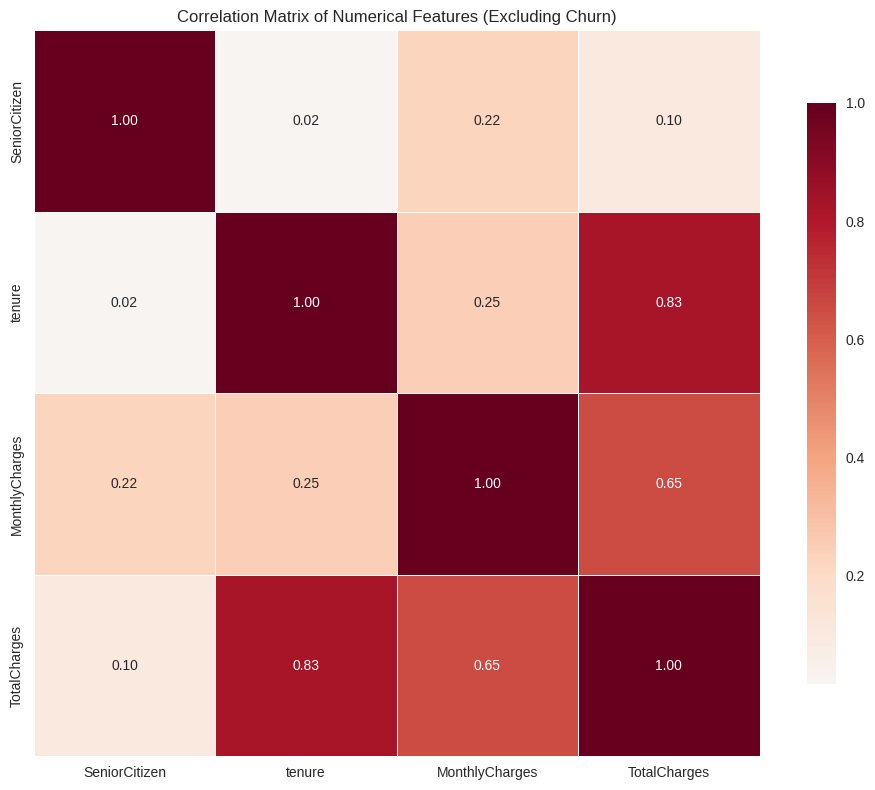


TOP STRONGEST CORRELATIONS BETWEEN NUMERICAL FEATURES

Top 5 strongest correlations:
1. tenure ↔ TotalCharges: 0.826 (positive)
2. MonthlyCharges ↔ TotalCharges: 0.651 (positive)
3. tenure ↔ MonthlyCharges: 0.248 (positive)
4. SeniorCitizen ↔ MonthlyCharges: 0.220 (positive)
5. SeniorCitizen ↔ TotalCharges: 0.103 (positive)

MULTICOLLINEARITY CHECK (Correlations > 0.7)
Found 1 high correlation pairs (potential multicollinearity):
  • tenure ↔ TotalCharges: 0.826

CORRELATION STATISTICAL SUMMARY
Total correlation pairs analyzed: 6
Average correlation: 0.344
Median correlation: 0.234
Positive correlations: 6 (100.0%)
Negative correlations: 0 (0.0%)
Strong correlations (>0.7): 1
Moderate correlations (0.5-0.7): 1
Weak correlations (<0.5): 4


In [10]:
print("\n1.6 CORRELATION ANALYSIS (Numerical Features Only - No Churn)")

# Prepare data for correlation - only numerical features
df_numerical = df_clean.copy()

# Select only numerical columns (exclude object/string columns)
numerical_cols = df_numerical.select_dtypes(include=[np.number]).columns.tolist()

# Include SeniorCitizen (it's already integer 0/1)
if 'SeniorCitizen' not in numerical_cols and 'SeniorCitizen' in df_numerical.columns:
    df_numerical['SeniorCitizen'] = df_numerical['SeniorCitizen'].astype(int)
    numerical_cols.append('SeniorCitizen')

# Check what numerical columns we have
print(f"Numerical features available: {numerical_cols}")

# Create correlation matrix with only numerical features (NO Churn included)
df_corr_numerical = df_numerical[numerical_cols]
correlation_matrix = df_corr_numerical.corr()

print("\nCorrelation Matrix of Numerical Features (without Churn):")
print("=" * 60)

# Display correlation matrix as a formatted table
print("\nCorrelation coefficients between numerical features:")
print("-" * 60)
for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        feature1 = numerical_cols[i]
        feature2 = numerical_cols[j]
        corr_value = correlation_matrix.loc[feature1, feature2]

        # Only print significant correlations
        if abs(corr_value) > 0.3:  # You can adjust this threshold
            strength = "Strong" if abs(corr_value) > 0.7 else "Moderate" if abs(corr_value) > 0.5 else "Weak"
            direction = "positive" if corr_value > 0 else "negative"
            print(f"{feature1:20} ↔ {feature2:20}: {corr_value:7.3f} ({strength} {direction} correlation)")

# Heatmap for numerical features only (without Churn)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features (Excluding Churn)')
plt.tight_layout()
plt.show()

# Find the strongest correlations
print("\n" + "=" * 60)
print("TOP STRONGEST CORRELATIONS BETWEEN NUMERICAL FEATURES")
print("=" * 60)

# Create a list of all unique correlation pairs
correlations_list = []
for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        feature1 = numerical_cols[i]
        feature2 = numerical_cols[j]
        corr_value = correlation_matrix.loc[feature1, feature2]
        correlations_list.append({
            'feature1': feature1,
            'feature2': feature2,
            'correlation': corr_value,
            'abs_correlation': abs(corr_value)
        })

# Sort by absolute correlation value
correlations_list.sort(key=lambda x: x['abs_correlation'], reverse=True)

# Print top 5 strongest correlations
print("\nTop 5 strongest correlations:")
for idx, corr_info in enumerate(correlations_list[:5]):
    feature1 = corr_info['feature1']
    feature2 = corr_info['feature2']
    corr_value = corr_info['correlation']
    direction = "positive" if corr_value > 0 else "negative"

    print(f"{idx+1}. {feature1} ↔ {feature2}: {corr_value:.3f} ({direction})")

# Check for potential multicollinearity
print("\n" + "=" * 60)
print("MULTICOLLINEARITY CHECK (Correlations > 0.7)")
print("=" * 60)

high_correlations = []
for corr_info in correlations_list:
    if corr_info['abs_correlation'] > 0.7:
        high_correlations.append(corr_info)

if high_correlations:
    print(f"Found {len(high_correlations)} high correlation pairs (potential multicollinearity):")
    for corr_info in high_correlations:
        print(f"  • {corr_info['feature1']} ↔ {corr_info['feature2']}: {corr_info['correlation']:.3f}")
else:
    print("No strong multicollinearity detected (all correlations < 0.7)")

# Statistical summary of correlations
print("\n" + "=" * 60)
print("CORRELATION STATISTICAL SUMMARY")
print("=" * 60)

# Calculate correlation statistics
all_correlations = [c['correlation'] for c in correlations_list]
positive_correlations = [c for c in all_correlations if c > 0]
negative_correlations = [c for c in all_correlations if c < 0]

print(f"Total correlation pairs analyzed: {len(correlations_list)}")
print(f"Average correlation: {np.mean(all_correlations):.3f}")
print(f"Median correlation: {np.median(all_correlations):.3f}")
print(f"Positive correlations: {len(positive_correlations)} ({len(positive_correlations)/len(all_correlations)*100:.1f}%)")
print(f"Negative correlations: {len(negative_correlations)} ({len(negative_correlations)/len(all_correlations)*100:.1f}%)")
print(f"Strong correlations (>0.7): {len([c for c in all_correlations if abs(c) > 0.7])}")
print(f"Moderate correlations (0.5-0.7): {len([c for c in all_correlations if 0.5 <= abs(c) < 0.7])}")
print(f"Weak correlations (<0.5): {len([c for c in all_correlations if abs(c) < 0.5])}")

# TASK 2: Model Development

In [11]:
print("\nTASK 2: MODEL DEVELOPMENT")


TASK 2: MODEL DEVELOPMENT


## Data Preparation

In [12]:
print("\n2.1 DATA PREPARATION FOR MODELING")

df_model = df_clean.copy()

# Encode binary columns
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
label_encoder = LabelEncoder()

for col in binary_cols:
    df_model[col] = label_encoder.fit_transform(df_model[col])
    print(f"  {col}: {label_encoder.classes_} → {label_encoder.transform(label_encoder.classes_)}")


# One-hot encode multi-category columns
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
'Contract', 'PaymentMethod']

df_model = pd.get_dummies(df_model, columns=multi_cat_cols, drop_first=True)
print(f"  One-hot encoded {len(multi_cat_cols)} multi-category columns")

# Encode target variable
df_model['Churn'] = df_model['Churn'].map({'Yes': 1, 'No': 0})
print(f"\nDataset shape after preprocessing: {df_model.shape}")

# Split features and target
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

print(f"\nFeature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain-Test Split Results:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training churn rate: {y_train.mean()*100:.1f}%")

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f" Class 0: {sum(y_train_res == 0):,} samples")
print(f" Class 1: {sum(y_train_res == 1):,} samples")
print(f" Synthetic samples created: {sum(y_train_res == 1) - sum(y_train == 1):,}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Keep unscaled for Decision Tree
X_train_unscaled = X_train_res
X_test_unscaled = X_test

print("\nFeature scaling completed")


2.1 DATA PREPARATION FOR MODELING
  gender: ['Female' 'Male'] → [0 1]
  Partner: ['No' 'Yes'] → [0 1]
  Dependents: ['No' 'Yes'] → [0 1]
  PhoneService: ['No' 'Yes'] → [0 1]
  PaperlessBilling: ['No' 'Yes'] → [0 1]
  One-hot encoded 10 multi-category columns

Dataset shape after preprocessing: (7043, 31)

Feature matrix (X) shape: (7043, 30)
Target vector (y) shape: (7043,)

Train-Test Split Results:
Training set: 5,634 samples
Test set: 1,409 samples
Training churn rate: 26.5%

After SMOTE:
 Class 0: 4,139 samples
 Class 1: 4,139 samples
 Synthetic samples created: 2,644

Feature scaling completed


## Model 1: Decision Tree


2.2 DECISION TREE WITH CCP PRUNING
Training baseline Decision Tree...
Baseline Decision Tree Accuracy: 0.7218

Applying Cost-Complexity Pruning (CCP)...

Best alpha: 0.0006294232188369803
Train Accuracy: 0.8360
Test Accuracy: 0.7559
ROC AUC: 0.8174

Final Pruned Decision Tree Accuracy: 0.7559

Top 10 Most Important Features:
------------------------------------------------------------
29. PaymentMethod_Electronic check 0.4182
 5. tenure........................ 0.2001
12. InternetService_Fiber optic... 0.1143
 4. Dependents.................... 0.0596
 9. TotalCharges.................. 0.0480
 8. MonthlyCharges................ 0.0386
28. PaymentMethod_Credit card (automatic) 0.0206
 6. PhoneService.................. 0.0182
11. MultipleLines_Yes............. 0.0148
23. StreamingTV_Yes............... 0.0144


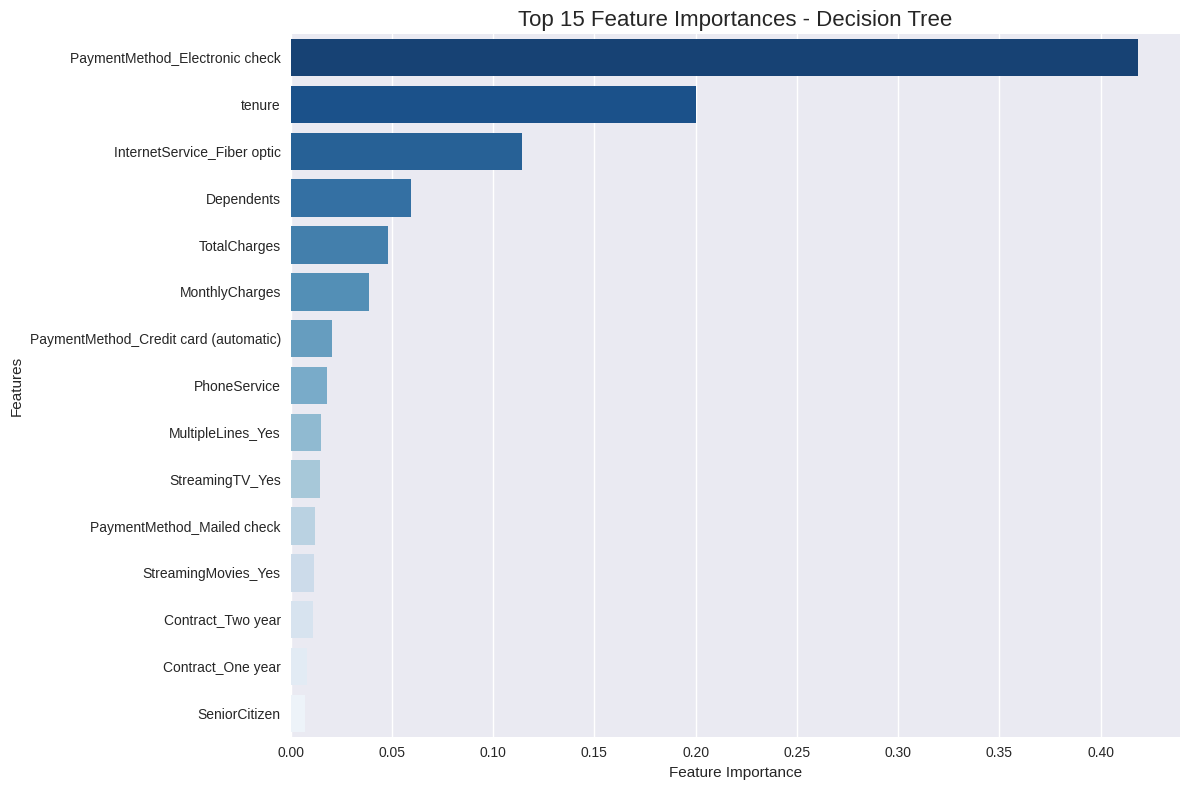

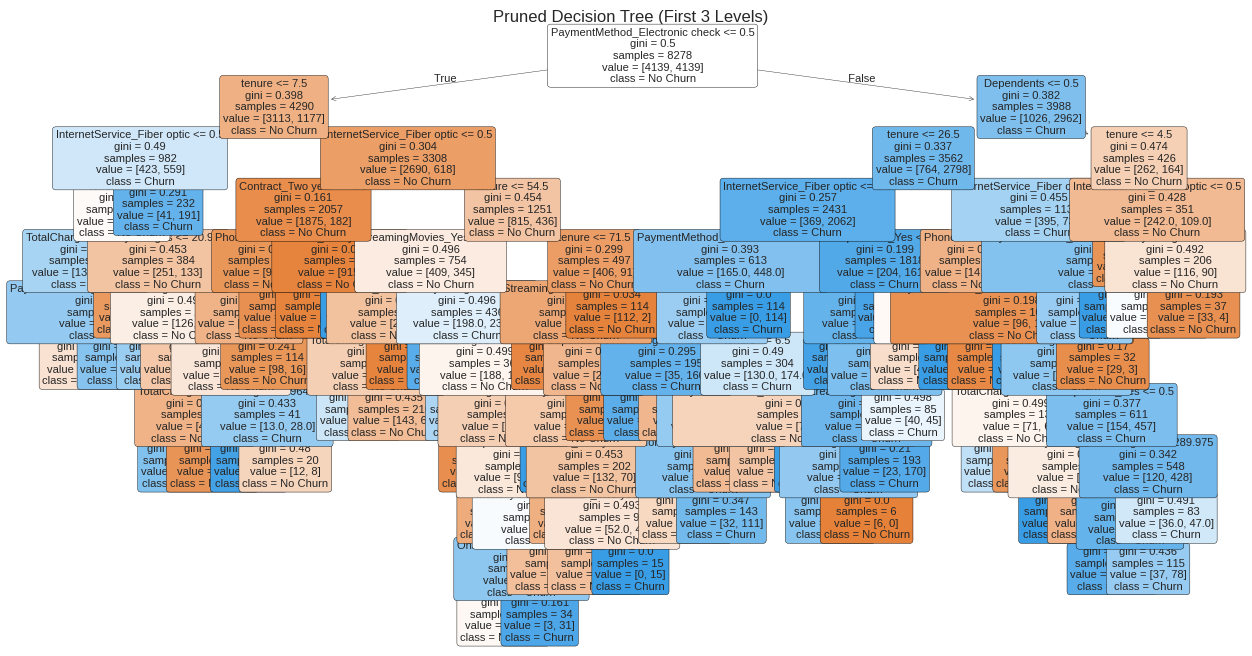

In [13]:
print("\n2.2 DECISION TREE WITH CCP PRUNING")

# Define blue_palette for consistent plotting
blue_palette = sns.color_palette("Blues_r", n_colors=15)

# Train baseline Decision Tree
print("Training baseline Decision Tree...")
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_unscaled, y_train_res)

y_pred_baseline = dt_baseline.predict(X_test_unscaled)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Decision Tree Accuracy: {baseline_accuracy:.4f}")

# CCP Pruning
print("\nApplying Cost-Complexity Pruning (CCP)...")
path = dt_baseline.cost_complexity_pruning_path(X_train_unscaled, y_train_res)
ccp_alphas = path.ccp_alphas

# Train pruned models
models = []
for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    pruned_tree.fit(X_train_unscaled, y_train_res)
    models.append(pruned_tree)

# Evaluate all pruned models
train_acc = []
test_acc = []
test_auc = []

for model in models:
    train_acc.append(accuracy_score(y_train_res, model.predict(X_train_unscaled)))
    test_acc.append(accuracy_score(y_test, model.predict(X_test_unscaled)))
    y_prob = model.predict_proba(X_test_unscaled)[:, 1]
    test_auc.append(roc_auc_score(y_test, y_prob))

# Select best model
best_index = test_auc.index(max(test_auc))
best_alpha = ccp_alphas[best_index]

print(f"\nBest alpha: {best_alpha}")
print(f"Train Accuracy: {train_acc[best_index]:.4f}")
print(f"Test Accuracy: {test_acc[best_index]:.4f}")
print(f"ROC AUC: {test_auc[best_index]:.4f}")

# Train final pruned model
best_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
best_dt.fit(X_train_unscaled, y_train_res)
y_pred_dt = best_dt.predict(X_test_unscaled)
y_prob_dt = best_dt.predict_proba(X_test_unscaled)[:, 1]

print(f"\nFinal Pruned Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print("-" * 60)
for i, row in feature_importance.head(10).iterrows():
    print(f"{i+1:2d}. {row['feature']:.<30} {row['importance']:.4f}")

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette=blue_palette)
plt.title('Top 15 Feature Importances - Decision Tree', fontsize=16)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Plot pruned tree (first 3 levels)
plt.figure(figsize=(15, 8))
plot_tree(best_dt, feature_names=X.columns, class_names=['No Churn', 'Churn'],
          filled=True, rounded=True, fontsize=8)
plt.title('Pruned Decision Tree (First 3 Levels)')
plt.show()

## Model 2: Neural Network


2.3 NEURAL NETWORK
Training baseline Neural Network...

Baseline Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 14,785 (57.75 KB)

 Non-trainable params: 448 (1.75 KB)


Training baseline Neural Network...
Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7162 - loss: 0.5872 - precision: 0.7100 - recall: 0.7290 - val_accuracy: 0.8031 - val_loss: 0.4279 - val_precision: 0.7948 - val_recall: 0.8179 - learning_rate: 0.0010
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7728 - loss: 0.4628 - precision: 0.7577 - recall: 0.7914 - val_accuracy: 0.8158 - val_loss: 0.3985 - val_precision: 0.8025 - val_recall: 0.8384 - learning_rate: 0.0010
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8010 - loss: 0.4298 - precision: 0.7940 - recall: 0.8003 - val_accuracy: 0.8243 - val_loss: 0.3832 - val_precision: 0.8172 - val_recall: 0.8359 - learning_rate: 0.0010
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8019 - loss: 0.4394 - precision: 0.7994 - recall: 0.8074 - val_accuracy: 0.8188 - val_loss: 0.3857 - val_precision: 0.8214 - val_recall: 0.8154 - learning_rate: 0.0010
Epoch 5/100
207/207 ━━

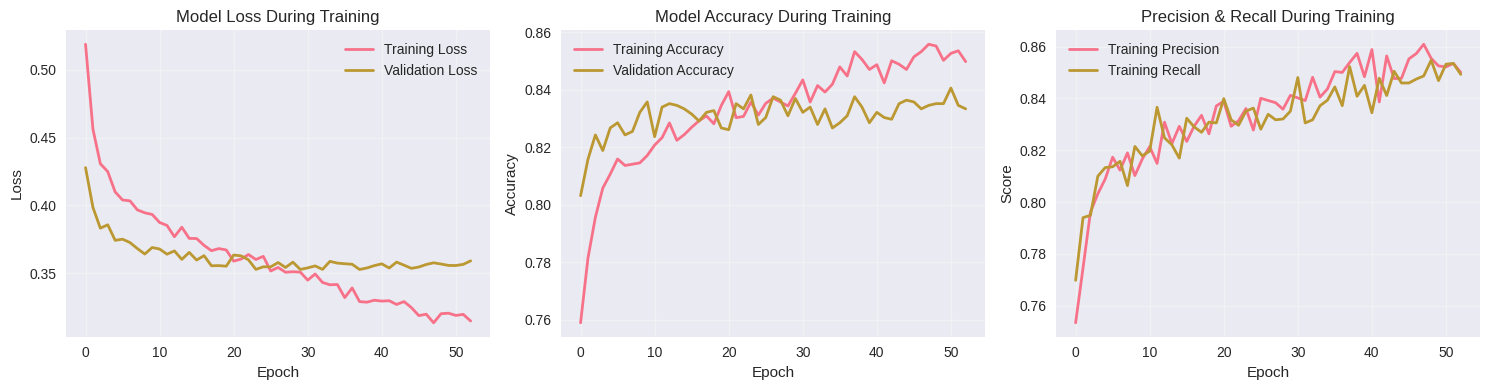


Performing hyperparameter tuning with KerasTuner...
Reloading Tuner from keras_tuner/churn_prediction/tuner0.json

Best hyperparameters found:
 Layer 1 units: 64
 Layer 1 dropout: 0.5
 Layer 2 units: 64
 Add third layer: True
 Layer 3 units: 32
 Layer 3 dropout: 0.2
 Learning rate: 0.001

Best Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,897 (34.75 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 320 (1.25 KB)

Tuned NN Validation Accuracy: 0.8460
Tuned NN Test Accuracy: 0.7771

MODEL COMPARISON
Baseline NN Test Accuracy:    0.7764
Tuned NN Test Accuracy:       0.7771
Improvement:                   +0.0007
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [14]:
print("\n2.3 NEURAL NETWORK")

# Create validation split
X_train_final, X_val, y_train_final, y_val = train_test_split(
X_train_scaled, y_train_res, test_size=0.2, random_state=42
)

# Baseline Neural Network
print("Training baseline Neural Network...")
def build_baseline_nn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

baseline_nn = build_baseline_nn((X_train_scaled.shape[1],))

# Callbacks for baseline
baseline_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
]

print("\nBaseline Neural Network Architecture:")
baseline_nn.summary()

print("\nTraining baseline Neural Network...")
history_baseline = baseline_nn.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=baseline_callbacks,
    verbose=1
)

print(f"\nTraining stopped at epoch {len(history_baseline.history['loss'])}")

# Evaluate baseline model
baseline_val_results = baseline_nn.evaluate(X_val, y_val, verbose=0)
val_loss = baseline_val_results[0]
val_acc = baseline_val_results[1]

baseline_test_results = baseline_nn.evaluate(X_test_scaled, y_test, verbose=0)
test_loss = baseline_test_results[0]
test_acc = baseline_test_results[1]

print(f"Baseline NN Validation Accuracy: {val_acc:.4f}")
print(f"Baseline NN Test Accuracy: {test_acc:.4f}")

# Plot baseline training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history_baseline.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_baseline.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_baseline.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history_baseline.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy During Training')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Check if precision/recall keys exist
available_keys = list(history_baseline.history.keys())
precision_keys = [k for k in available_keys if 'precision' in k.lower()]
recall_keys = [k for k in available_keys if 'recall' in k.lower()]

if precision_keys and recall_keys:
    axes[2].plot(history_baseline.history[precision_keys[0]], label='Training Precision', linewidth=2)
    axes[2].plot(history_baseline.history[recall_keys[0]], label='Training Recall', linewidth=2)
    axes[2].set_title('Precision & Recall During Training')
else:
    # Fallback: Plot validation accuracy vs training accuracy
    axes[2].plot(history_baseline.history['accuracy'], label='Training Accuracy', linewidth=2, alpha=0.7)
    axes[2].plot(history_baseline.history['val_accuracy'], label='Validation Accuracy', linewidth=2, alpha=0.7)
    axes[2].set_title('Training vs Validation Accuracy')

axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Score')
axes[2].legend()
axes[2].grid(alpha=0.3)


plt.tight_layout()
plt.show()

# Hyperparameter tuning with KerasTuner
print("\nPerforming hyperparameter tuning with KerasTuner...")

def build_model(hp):
    model = Sequential()
    # First layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=64, max_value=256, step=64),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1)))

    # Optional third layer
    if hp.Boolean('add_third_layer'):
        model.add(Dense(
            units=hp.Int('units_3', min_value=16, max_value=64, step=16),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.3, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

    )

    return model

# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner',
    project_name='churn_prediction'
)

# Callbacks for tuning
tuner_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Search for best hyperparameters
tuner.search(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=tuner_callbacks,
    verbose=1
)

# Get best model and hyperparameters
best_nn = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest hyperparameters found:")
print(f" Layer 1 units: {best_hp.get('units_1')}")
print(f" Layer 1 dropout: {best_hp.get('dropout_1')}")
print(f" Layer 2 units: {best_hp.get('units_2')}")
print(f" Add third layer: {best_hp.get('add_third_layer')}")
if best_hp.get('add_third_layer'):
    print(f" Layer 3 units: {best_hp.get('units_3')}")
    print(f" Layer 3 dropout: {best_hp.get('dropout_3')}")
print(f" Learning rate: {best_hp.get('learning_rate')}")

print("\nBest Neural Network Architecture:")
best_nn.summary()

# Evaluate best model
tuned_val_results = best_nn.evaluate(X_val, y_val, verbose=0)
val_loss_best = tuned_val_results[0]
val_acc_best = tuned_val_results[1]

tuned_test_results = best_nn.evaluate(X_test_scaled, y_test, verbose=0)
test_loss_best = tuned_test_results[0]
test_acc_best = tuned_test_results[1]

print(f"Tuned NN Validation Accuracy: {val_acc_best:.4f}")
print(f"Tuned NN Test Accuracy: {test_acc_best:.4f}")

# Compare with baseline
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Baseline NN Test Accuracy:    {test_acc:.4f}")
print(f"Tuned NN Test Accuracy:       {test_acc_best:.4f}")
improvement = test_acc_best - test_acc
print(f"Improvement:                   {improvement:+.4f}")

# Predictions
y_pred_nn = (best_nn.predict(X_test_scaled) > 0.5).astype("int32").flatten()
y_prob_nn = best_nn.predict(X_test_scaled).flatten()



## Model Evaluation


2.4 MODEL EVALUATION


Decision Tree Evaluation:
------------------------------
Accuracy:  0.7559
Precision: 0.5299
Recall:    0.7112
F1-Score:  0.6073
ROC-AUC:   0.8174

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.77      0.82      1035
       Churn       0.53      0.71      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409



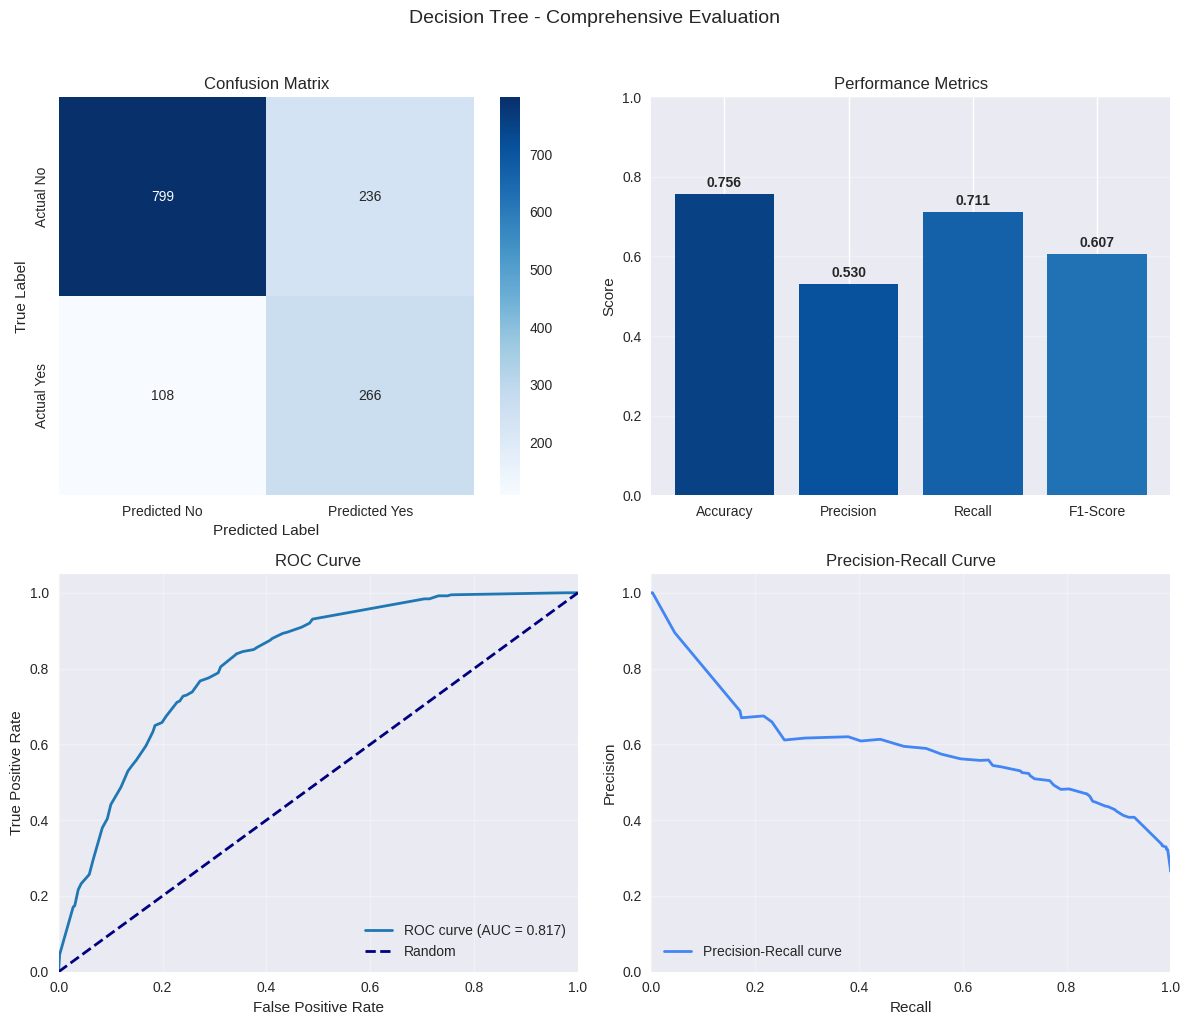



Neural Network Evaluation:
------------------------------
Accuracy:  0.7771
Precision: 0.5754
Recall:    0.6123
F1-Score:  0.5933
ROC-AUC:   0.8322

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      0.84      0.85      1035
       Churn       0.58      0.61      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



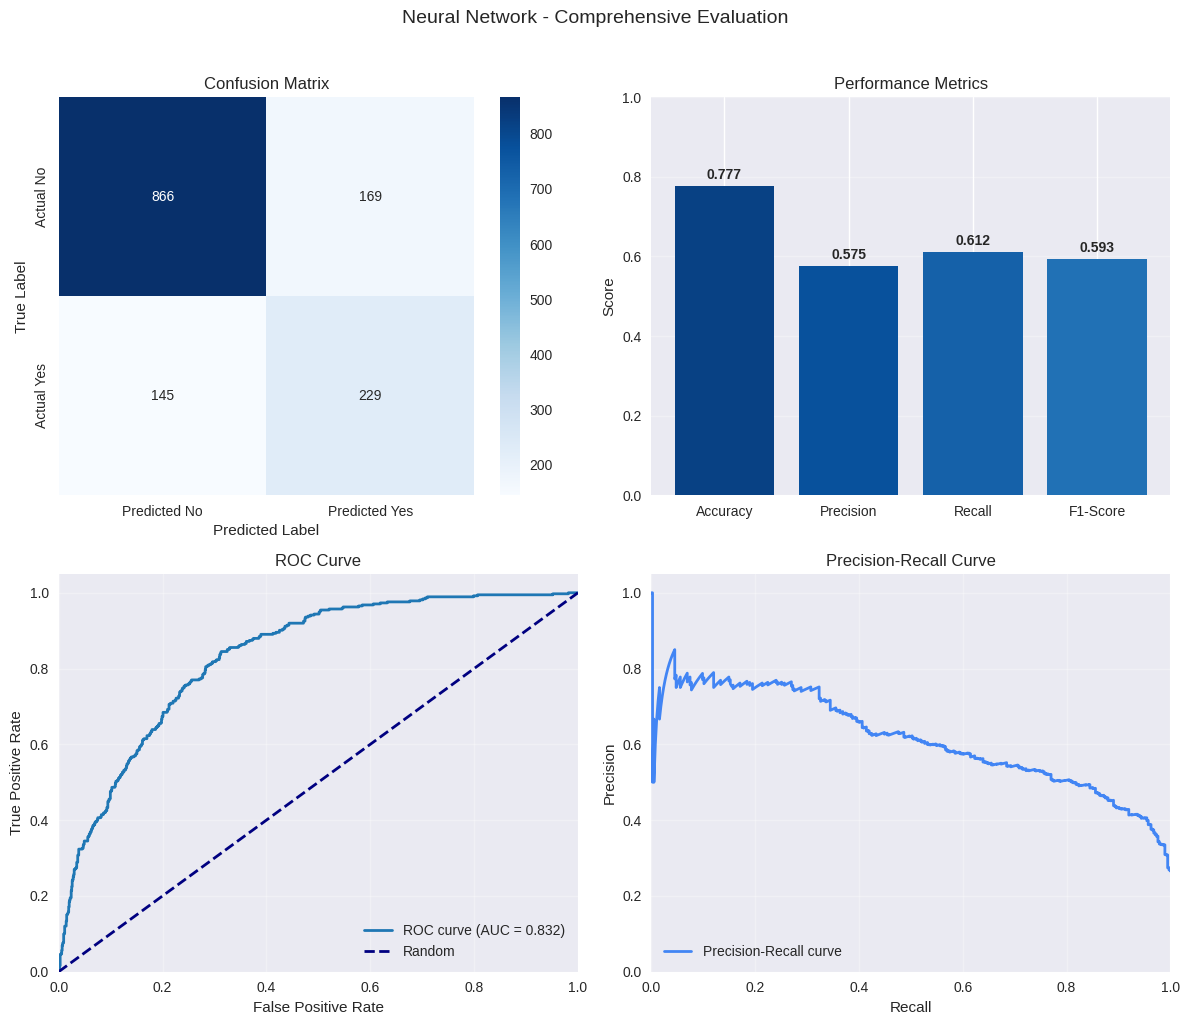

In [15]:
print("\n2.4 MODEL EVALUATION")

# Function for comprehensive evaluation
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"\n{model_name} Evaluation:")
    print("-" * 30)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Churn', 'Churn']))

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')

    # 2. Performance Metrics Bar Chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    scores = [accuracy, precision, recall, f1]
    bars = axes[0,1].bar(metrics, scores, color=blue_palette[:4])
    axes[0,1].set_title('Performance Metrics')
    axes[0,1].set_ylabel('Score')
    axes[0,1].set_ylim(0, 1)
    axes[0,1].grid(axis='y', alpha=0.3)

    for bar, score in zip(bars, scores):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[1,0].plot(fpr, tpr, color='#1f77b4', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[1,0].set_xlim([0.0, 1.0])
    axes[1,0].set_ylim([0.0, 1.05])
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curve')
    axes[1,0].legend(loc='lower right')
    axes[1,0].grid(alpha=0.3)

    # 4. Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
    axes[1,1].plot(recall_curve, precision_curve, color='#4285f4', lw=2, label='Precision-Recall curve')
    axes[1,1].set_xlim([0.0, 1.0])
    axes[1,1].set_ylim([0.0, 1.05])
    axes[1,1].set_xlabel('Recall')
    axes[1,1].set_ylabel('Precision')
    axes[1,1].set_title('Precision-Recall Curve')
    axes[1,1].legend(loc='lower left')
    axes[1,1].grid(alpha=0.3)

    plt.suptitle(f'{model_name} - Comprehensive Evaluation', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall,
            'f1': f1, 'auc': auc}

# Evaluate models
print("\n" + "="*50)
dt_results = evaluate_model(y_test, y_pred_dt, y_prob_dt, "Decision Tree")
print("\n" + "="*50)
nn_results = evaluate_model(y_test, y_pred_nn, y_prob_nn, "Neural Network")

## Model Comparison


2.5 MODEL COMPARISON

Model Performance Comparison:


,Metric,Decision Tree,Neural Network
0,Accuracy,0.7559,0.7771
1,Precision,0.5299,0.5754
2,Recall,0.7112,0.6123
3,F1-Score,0.6073,0.5933
4,ROC-AUC,0.8174,0.8322


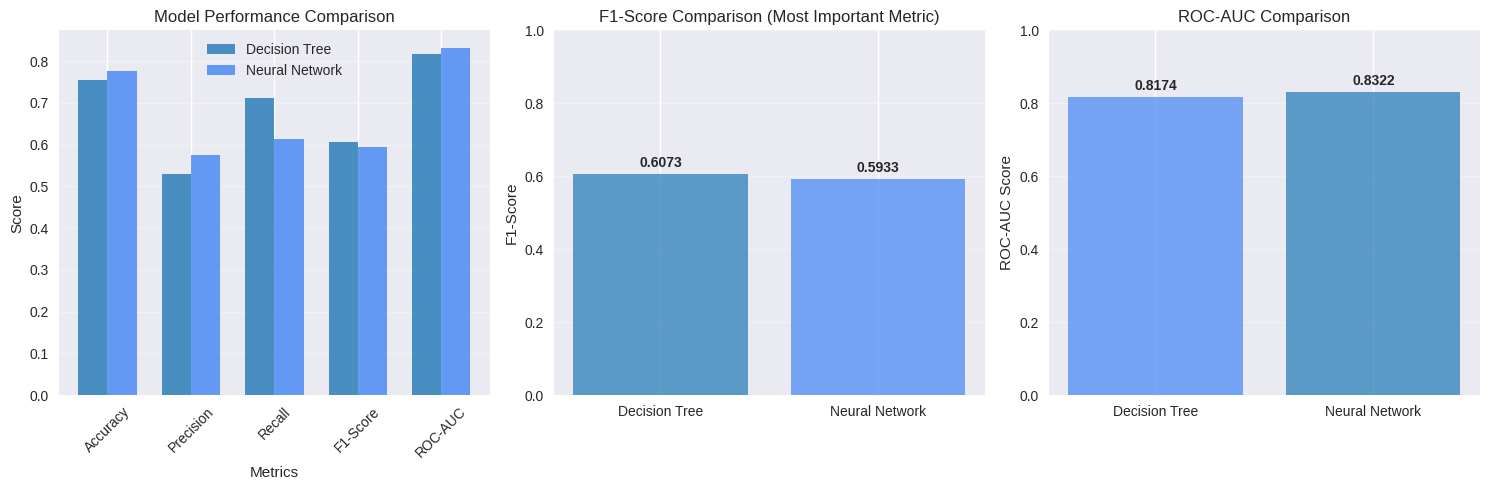


Best Model: Decision Tree
Best F1-Score: 0.6073

Baseline vs Tuned Models:
----------------------------------------
Model                    Baseline    Tuned       Improvement
----------------------------------------
Decision Tree            0.7218      0.7559      +0.0341
Neural Network           0.7764      0.7771      +0.0007


In [16]:
print("\n2.5 MODEL COMPARISON")

# Create comparison table
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Decision Tree': [
        dt_results['accuracy'],
        dt_results['precision'],
        dt_results['recall'],
        dt_results['f1'],
        dt_results['auc']
    ],
    'Neural Network': [
        nn_results['accuracy'],
        nn_results['precision'],
        nn_results['recall'],
        nn_results['f1'],
        nn_results['auc']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
display(comparison_df.round(4))

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bar chart comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(metrics))
width = 0.35

axes[0].bar(x_pos - width/2, comparison_df['Decision Tree'], width,
            label='Decision Tree', alpha=0.8, color='#1f77b4')
axes[0].bar(x_pos + width/2, comparison_df['Neural Network'], width,
            label='Neural Network', alpha=0.8, color='#4285f4')

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# F1-Score focus
models = ['Decision Tree', 'Neural Network']
f1_scores = [dt_results['f1'], nn_results['f1']]
colors = ['#1f77b4', '#4285f4'] if dt_results['f1'] > nn_results['f1'] else ['#4285f4', '#1f77b4']

bars = axes[1].bar(models, f1_scores, color=colors, alpha=0.7)
axes[1].set_title('F1-Score Comparison (Most Important Metric)')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)

for bar, score in zip(bars, f1_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. ROC-AUC comparison
auc_scores = [dt_results['auc'], nn_results['auc']]
colors_auc = ['#1f77b4', '#4285f4'] if dt_results['auc'] > nn_results['auc'] else ['#4285f4', '#1f77b4']

bars_auc = axes[2].bar(models, auc_scores, color=colors_auc, alpha=0.7)
axes[2].set_title('ROC-AUC Comparison')
axes[2].set_ylabel('ROC-AUC Score')
axes[2].set_ylim(0, 1)
axes[2].grid(axis='y', alpha=0.3)

for bar, score in zip(bars_auc, auc_scores):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Determine best model
if dt_results['f1'] > nn_results['f1']:
    best_model = 'Decision Tree'
    best_f1 = dt_results['f1']
else:
    best_model = 'Neural Network'
    best_f1 = nn_results['f1']

print(f"\nBest Model: {best_model}")
print(f"Best F1-Score: {best_f1:.4f}")

# Baseline vs Tuned comparison
print("\nBaseline vs Tuned Models:")
print("-" * 40)
print(f"{'Model':<25}{'Baseline':<12}{'Tuned':<12}{'Improvement'}")
print("-" * 40)
print(f"{'Decision Tree':<25}{baseline_accuracy:<12.4f}{dt_results['accuracy']:<12.4f}{dt_results['accuracy'] - baseline_accuracy:+.4f}")
print(f"{'Neural Network':<25}{test_acc:<12.4f}{nn_results['accuracy']:<12.4f}{nn_results['accuracy'] - test_acc:+.4f}")

##